### 读取提取模板所保存的光谱数据

In [61]:
import pandas as pd 
import numpy as np
df = pd.read_csv(rf'I:\experiment_data\莲蓉混合\Spectrum_analyse\莲蓉黄豌豆蓉混合.csv' , index_col = 0)
labels = df.index.values

spectrum = df.values
spectrum = spectrum
wave = [float(i) for i in df.columns.values]
wave = wave

In [62]:
labels = [i[:5] for i in df.index.values]

### 绘图查看数据情况

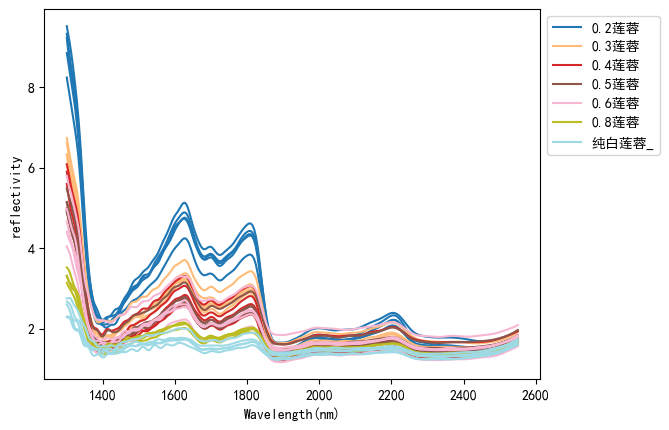

In [63]:
import importlib
import SpectrumAnalyse  # 导入模块

# 导入需要的函数
from SpectrumAnalyse import plot_duplicate_data, split_data
import matplotlib.pyplot as plt

category,  split_datas = split_data(labels , spectrum)
plot_duplicate_data(category,  split_datas , wave , type='all') 


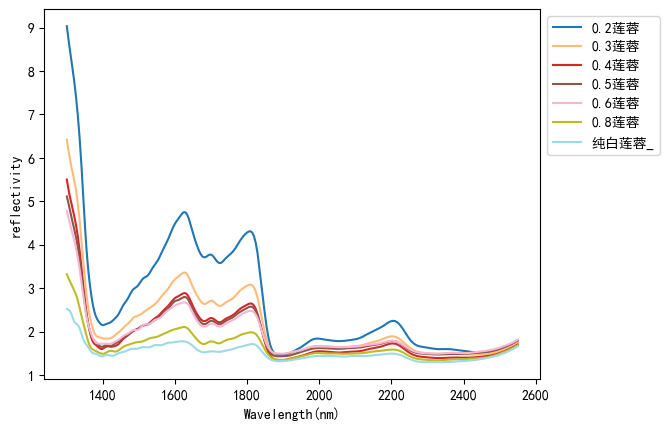

In [64]:
plot_duplicate_data(category,  split_datas , wave , type='mean') 


In [65]:
from SpectrumAnalyse import snv
reflectance_snv = snv(spectrum)

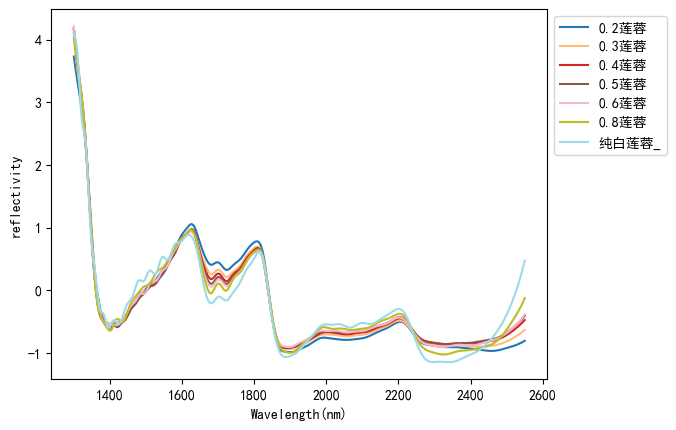

In [66]:
category,  split_datas = split_data(labels , reflectance_snv)
plot_duplicate_data(category,  split_datas , wave , type='mean') 



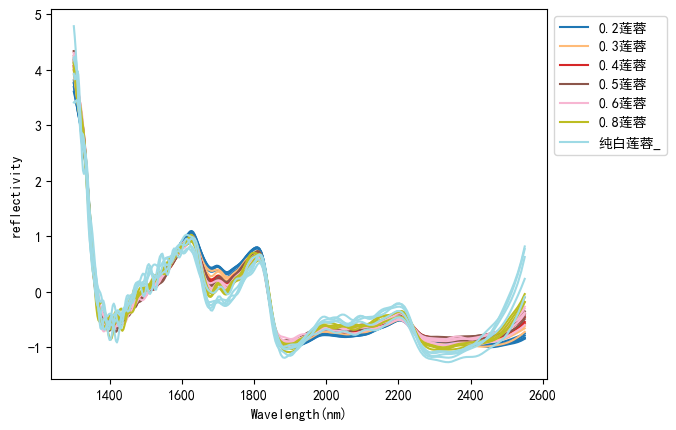

In [ ]:
plot_duplicate_data(category,  split_datas , wave , type='all') 

### 预处理方法列表

In [68]:


import numpy as np
import pandas as pd
from tqdm import tqdm  # 导入 tqdm 库

# 假设你已经定义了这些预处理函数
def msc(ori_specs):
    """多元散射校正"""
    me = np.mean(ori_specs, axis=0)
    msc_specs = np.zeros_like(ori_specs)
    for i in range(ori_specs.shape[0]):
        poly = np.polyfit(me, ori_specs[i], 1)
        msc_specs[i] = (ori_specs[i] - poly[1]) / poly[0]
    return msc_specs

def snv(ori_specs):
    """标准正态化"""
    snv_specs = np.zeros_like(ori_specs)
    for i in range(ori_specs.shape[0]):
        snv_specs[i] = (ori_specs[i] - np.mean(ori_specs[i])) / np.std(ori_specs[i])
    return snv_specs

def CT(data):
    """均值中心化"""
    for i in range(data.shape[1]):
        mean_val = np.mean(data[:, i])
        data[:, i] = data[:, i] - mean_val
    return data

def MA(data, WSZ=11):
    """移动平均平滑"""
    for i in range(data.shape[0]):
        out0 = np.convolve(data[i], np.ones(WSZ, dtype=int), 'valid') / WSZ
        r = np.arange(1, WSZ - 1, 2)
        start = np.cumsum(data[i, :WSZ - 1])[::2] / r
        stop = (np.cumsum(data[i, :-WSZ:-1])[::2] / r)[::-1]
        data[i] = np.concatenate((start, out0, stop))
    return data

def SG(data, w=11, p=2):
    """SG平滑"""
    from scipy.signal import savgol_filter
    return savgol_filter(data, w, p)

def none(data):
    """无预处理"""
    return data

def pca(data):
    """PCA降维"""
    from sklearn.decomposition import PCA
    pca = PCA(n_components=25)
    return pca.fit_transform(data)

preprocessing_functions = {
    'MSC': msc,
    'SNV': snv,
    'CT': CT,
    'MA': MA,
    'SG': SG,
    'PCA': pca,
    '不做任何预处理': none
}


### 网格调参结合各种预处理方法选优

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# 定义SVM模型
model = SVC()

# 定义参数网格
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10],  # 惩罚参数
    'kernel': ['linear', 'rbf', 'poly'],  # 核函数类型
    'gamma': ['scale', 'auto', 0.1, 1, 10]  # 核函数的gamma值
}

from sklearn.model_selection import StratifiedKFold

# 使用 StratifiedKFold 并传递 random_state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
# 创建GridSearchCV对象，使用5折交叉验证（可以调整交叉验证的折数）
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy' )

test_results = []

# 使用 tqdm 进行进度条显示
for name, func in tqdm(preprocessing_functions.items(), desc="Processing Functions"):

    results = []
    print(f"正在测试：{name}")
    results.append(name)

    # Apply the preprocessing function
    processed_spectrum = func(spectrum)

    # Perform GridSearchCV to find the best parameters
    grid_search.fit(processed_spectrum, labels)

    # 输出最优参数和最优得分
    print(f"最优参数: {grid_search.best_params_}")
    results.append(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    best_score = k_fold_cross_validation(processed_spectrum, np.array(labels), best_model, n_splits=5 , random_state = 53 , show= False)

    print(f"最优交叉验证得分: {best_score}")
    results.append(np.array(best_score).round(2))

    test_results.append(results)



Processing Functions:   0%|          | 0/7 [00:00<?, ?it/s]d:\Anaconda\envs\spe\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


正在测试：MSC
Fitting 5 folds for each of 90 candidates, totalling 450 fits


Processing Functions:  14%|█▍        | 1/7 [00:14<01:26, 14.50s/it]

最优参数: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
最优交叉验证得分: 0.08823529411764706
正在测试：SNV
Fitting 5 folds for each of 90 candidates, totalling 450 fits


d:\Anaconda\envs\spe\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Processing Functions:  29%|██▊       | 2/7 [00:14<00:30,  6.17s/it]

最优参数: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证得分: 0.5882352941176471
正在测试：CT
Fitting 5 folds for each of 90 candidates, totalling 450 fits


d:\Anaconda\envs\spe\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Processing Functions:  43%|████▎     | 3/7 [00:15<00:14,  3.53s/it]

最优参数: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证得分: 0.7058823529411765
正在测试：MA
Fitting 5 folds for each of 90 candidates, totalling 450 fits


d:\Anaconda\envs\spe\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Processing Functions:  57%|█████▋    | 4/7 [00:15<00:06,  2.27s/it]

最优参数: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证得分: 0.7058823529411765
正在测试：SG
Fitting 5 folds for each of 90 candidates, totalling 450 fits


d:\Anaconda\envs\spe\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Processing Functions:  71%|███████▏  | 5/7 [00:15<00:03,  1.57s/it]

最优参数: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证得分: 0.7058823529411765
正在测试：PCA
Fitting 5 folds for each of 90 candidates, totalling 450 fits


d:\Anaconda\envs\spe\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Processing Functions:  86%|████████▌ | 6/7 [00:16<00:01,  1.14s/it]

最优参数: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证得分: 0.7058823529411765
正在测试：不做任何预处理
Fitting 5 folds for each of 90 candidates, totalling 450 fits


d:\Anaconda\envs\spe\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Processing Functions: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it]

最优参数: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证得分: 0.7058823529411765


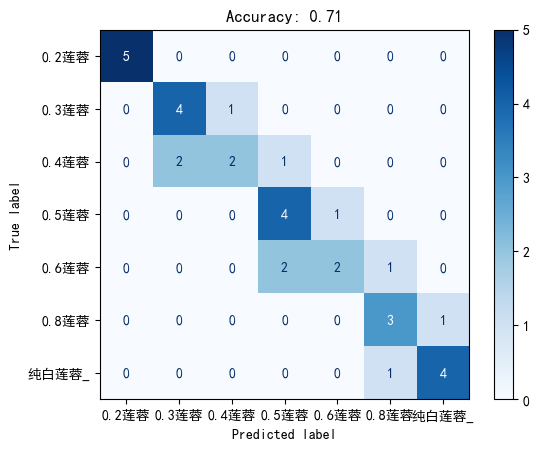

0.7058823529411765

In [98]:
best_model = grid_search.best_estimator_
k_fold_cross_validation(spectrum, np.array(labels), best_model, n_splits=5 , random_state = 53 )


In [97]:
pd.DataFrame(test_results)

,0,1,2
0,MSC,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.09
1,SNV,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.59
2,CT,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}",0.71
3,MA,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}",0.71
4,SG,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}",0.71
5,PCA,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}",0.71
6,不做任何预处理,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}",0.71


### 使用最优参数与预处理方法查看模型效果

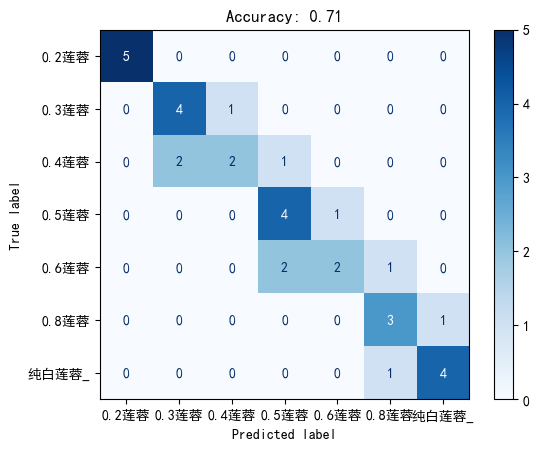

0.7058823529411765

In [100]:
import importlib
importlib.reload(SpectrumAnalyse)
from SpectrumAnalyse import k_fold_cross_validation



best_model = SVC(C=0.5, kernel='linear', gamma='scale')
k_fold_cross_validation(spectrum, np.array(labels), best_model, n_splits=5 , random_state = 53)


留一交叉验证的平均准确率: 0.62


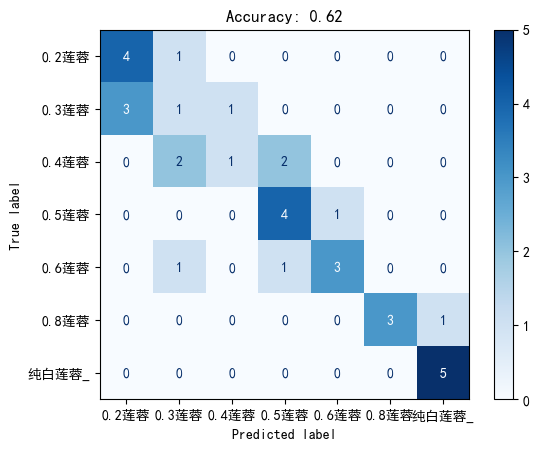

np.float64(0.6176470588235294)

In [72]:
from SpectrumAnalyse import  leave_one_out_cross_validation
leave_one_out_cross_validation(snv(spectrum), np.array(labels), best_model)

###  两批数据进行测试

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 读取训练和测试数据
df = pd.read_csv(rf'大烟叶原始反射光谱数据_split.csv', index_col=0)
labels = df.index.values
spectrum = df.values
spectrum = spectrum[:, 50:400]  # 选择需要的波长范围

df = pd.read_csv(rf'大烟叶原始反射光谱数据第二批_split.csv', index_col=0)
labels2 = df.index.values
spectrum2 = df.values
spectrum2 = spectrum2[:, 50:400]  # 选择需要的波长范围

train_X = spectrum
train_y = labels
test_X = spectrum2
test_y = labels2

In [13]:
test_results = []

# 使用 tqdm 进行进度条显示
for name, func in tqdm(preprocessing_functions.items(), desc="Processing Functions"):

    results  = []
    print(f"正在测试：{name}")
    results.append(name)
    processed_train_X = func(train_X)  # 应用预处理函数
    processed_test_X = func(test_X)  # 应用预处理函数

    grid_search_X = np.concatenate((processed_train_X ,processed_test_X ) ,axis=0)
    grid_search_y = np.concatenate((train_y ,test_y ) ,axis=0)
    grid_search.fit(grid_search_X, grid_search_y)
    # 输出最优参数和最优得分
    print(f"最优参数: {grid_search.best_params_}")
    results.append(grid_search.best_params_)
    print(f"最优交叉验证得分: {grid_search.best_score_}")
    results.append(grid_search.best_score_)
    # 使用测试集评估最优模型

    best_model = grid_search.best_estimator_
    best_model.fit(processed_train_X, train_y)
    y_pred = best_model.predict(processed_test_X)
    # 计算测试集的准确率
    accuracy = accuracy_score(test_y, y_pred)
    print(f"测试集准确率: {accuracy}")
    results.append(accuracy)
    test_results.append(results)




Processing Functions:   0%|          | 0/7 [00:00<?, ?it/s]

正在测试：MSC
Fitting 3 folds for each of 90 candidates, totalling 270 fits


Processing Functions:  14%|█▍        | 1/7 [00:03<00:19,  3.20s/it]

最优参数: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证得分: 0.5202703857526193
测试集准确率: 0.4098360655737705
正在测试：SNV
Fitting 3 folds for each of 90 candidates, totalling 270 fits


Processing Functions:  29%|██▊       | 2/7 [00:05<00:13,  2.69s/it]

最优参数: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证得分: 0.8092772052162914
测试集准确率: 0.6967213114754098
正在测试：CT
Fitting 3 folds for each of 90 candidates, totalling 270 fits


Processing Functions:  43%|████▎     | 3/7 [00:08<00:12,  3.04s/it]

最优参数: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
最优交叉验证得分: 0.77365020766036
测试集准确率: 0.7418032786885246
正在测试：MA
Fitting 3 folds for each of 90 candidates, totalling 270 fits


Processing Functions:  57%|█████▋    | 4/7 [00:12<00:09,  3.09s/it]

最优参数: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
最优交叉验证得分: 0.77365020766036
测试集准确率: 0.7418032786885246
正在测试：SG
Fitting 3 folds for each of 90 candidates, totalling 270 fits


Processing Functions:  71%|███████▏  | 5/7 [00:15<00:06,  3.08s/it]

最优参数: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
最优交叉验证得分: 0.77365020766036
测试集准确率: 0.7418032786885246
正在测试：PCA
Fitting 3 folds for each of 90 candidates, totalling 270 fits


Processing Functions:  86%|████████▌ | 6/7 [00:18<00:03,  3.03s/it]

最优参数: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证得分: 0.7583619614076467
测试集准确率: 0.639344262295082
正在测试：不做任何预处理
Fitting 3 folds for each of 90 candidates, totalling 270 fits


Processing Functions: 100%|██████████| 7/7 [00:21<00:00,  3.01s/it]

最优参数: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
最优交叉验证得分: 0.77365020766036
测试集准确率: 0.7418032786885246


In [ ]:
test_results = pd.DataFrame(test_results)
test_results

### 保存模型并且使用新的模型进行预测

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.svm import SVC
import  joblib
df = pd.read_csv(rf'H:\大烟叶数据\Spectrum_analyse\大烟叶原始反射光谱数据_split.csv' , index_col = 0)
labels = df.index.values

spectrum = df.values
spectrum = spectrum[:,50:400]
wave = [float(i) for i in df.columns.values]
wave = wave[50:400]


### 训练并且保存模型
model = SVC(C=1 ,  kernel='poly', gamma=1)
model.fit(spectrum, labels)
import  joblib
joblib.dump(model, 'dayanye.pkl')
print('模型保存成功')


In [ ]:
### 加载模型
model = joblib.load('dayanye.pkl')

import pandas as pd 
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as pl
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from SpectrumAnalyse import snv

df = pd.read_csv(rf'H:\大烟叶数据\Spectrum_analyse\大烟叶原始反射光谱数据第二批_split.csv' , index_col = 0)
labels2 = df.index.values

spectrum2 = df.values
spectrum2 = spectrum2[:,50:400]

wave = [float(i) for i in df.columns.values]
wave = wave[50:400]
### 模型预测并且绘制混淆矩阵
predit = model.predict(spectrum2)
cm = confusion_matrix(labels2, predit)

# 获取唯一的标签
unique_labels = np.unique(labels2)

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
accuracy = accuracy_score(labels2, predit)
plt.title(f"Accuracy: {accuracy:.2f}")
plt.show()
